In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split

import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# config
random_seed = 42
data_size = 100000
batch_size = 64
num_classes = 14
pos_weight = None

In [ ]:
def split_data(label_file, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    labels_df = pd.read_csv(label_file)[:data_size]
    
    train_df, temp_df = train_test_split(labels_df, test_size=(1 - train_ratio), random_state=random_seed)
    val_df, test_df = train_test_split(temp_df, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=random_seed)
    
    return train_df, val_df, test_df

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class CXRDataset(Dataset):
    def __init__(self, image_dir, labels_df, transform=None):
        self.image_dir = image_dir
        self.labels_df = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        
        img_name = row['ImageID']
        labels = row.iloc[:14].values.astype(int)
        
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(labels, dtype=torch.int64)

In [ ]:
label_file = "<file_location>/data_preprocessed.csv"
image_dir = "<file_location>"
train_df, val_df, test_df = split_data(label_file)

train_dataset = CXRDataset(image_dir=image_dir, labels_df=train_df, transform=transform)
val_dataset = CXRDataset(image_dir=image_dir, labels_df=val_df, transform=transform)
test_dataset = CXRDataset(image_dir=image_dir, labels_df=test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super(UNet, self).__init__()
        
        # U-Net Encoder: ResNet Backbone
        self.base_model = models.resnet34(pretrained=True)
        self.conv1 = self.base_model.conv1
        self.bn1 = self.base_model.bn1
        self.relu = self.base_model.relu
        self.maxpool = self.base_model.maxpool
        self.layer1 = self.base_model.layer1
        self.layer2 = self.base_model.layer2
        self.layer3 = self.base_model.layer3
        self.layer4 = self.base_model.layer4
        
        # U-Net Decoder
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(512, 256, dropout_rate)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128, dropout_rate)
        
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(128, 64, dropout_rate)
        
        # Segmentation Output
        self.seg_output = nn.Conv2d(64, num_classes, kernel_size=1)

        # Classification Head
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier_dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512 + 64, num_classes)  # Adjusted input size

    def conv_block(self, in_ch, out_ch, dropout_rate):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        # Encoder
        x1 = self.relu(self.bn1(self.conv1(x)))
        x2 = self.maxpool(x1)
        x3 = self.layer1(x2)
        x4 = self.layer2(x3)
        x5 = self.layer3(x4)
        x6 = self.layer4(x5)

        # Decoder
        up1 = self.up1(x6)
        dec1 = self.dec1(torch.cat([up1, x5], dim=1))

        up2 = self.up2(dec1)
        dec2 = self.dec2(torch.cat([up2, x4], dim=1))

        up3 = self.up3(dec2)
        dec3 = self.dec3(torch.cat([up3, x3], dim=1))

        # Segmentation Output
        # We plan to leverage segmentation output by using segmentation label in future experiments
        seg_output = self.seg_output(dec3)

        # Combine features from encoder and decoder for classification
        gap_x6 = self.gap(x6).view(x6.size(0), -1)
        gap_dec3 = self.gap(dec3).view(dec3.size(0), -1)
        combined_features = torch.cat([gap_x6, gap_dec3], dim=1)

        # Classification Head
        combined_features = self.classifier_dropout(combined_features)
        class_output = self.fc(combined_features)

        return class_output, seg_output

In [ ]:
model = UNet(num_classes, dropout_rate=0.3).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

/opt/homebrew/Caskroom/miniconda/base/envs/cmu24/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cmu24/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# checkpoint = torch.load("<model>.pth")
checkpoint = torch.load("<model>.pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# Test
- We need to test the model for deeper inspectation on layer-wise gradCAM result

In [ ]:
def test_model(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            class_output, _ = model(images)
            preds = torch.sigmoid(class_output) > 0.5

            predictions.append(preds.cpu())
            true_labels.append(labels.cpu())

    predictions = torch.cat(predictions, dim=0)
    true_labels = torch.cat(true_labels, dim=0)

    return predictions, true_labels

# Diagnosis Result
- We used below codes for get diagnosis (classification) result for each samples and inspect gradCAM results to get insights for diseases.

In [ ]:
data_count = 300

test_loader_sel = list(test_loader)[:data_count]
predictions, true_labels = test_model(model, test_loader_sel, device)

for i in range(0, data_count):    
    predicted_indices = [idx for idx, val in enumerate(predictions[i].int().numpy()) if val == 1]
    true_label_indices = [idx for idx, val in enumerate(true_labels[i].numpy()) if val == 1]

    print(f"Sample {i}:")
    print(f"Predicted: {', '.join(map(str, predicted_indices)) if predicted_indices else 'None'}")
    print(f"True Label: {', '.join(map(str, true_label_indices)) if true_label_indices else 'None'}")
    print("-" * 50)

# Double check the label!!

In [ ]:
data_idxs = [i for i in range(data_count)]

for data_idx in data_idxs:
    _, label = test_dataset[data_idx]
    label = label.unsqueeze(0).to(device)
    nonzero_indices = torch.nonzero(label[0]).view(-1)
    print(f"{data_idx}: {nonzero_indices.tolist()}")

0: [8]
1: [0, 13]
2: []
3: [8, 13]
4: [8]
5: [8, 13]
6: []
7: [0, 11]
8: [8]
9: [5, 7]
10: [4, 6, 9, 10]
11: [8]
12: [8]
13: [0, 1, 7, 11]
14: [1, 6, 7, 9]
15: [2, 9, 13]
16: [9, 10, 13]
17: [8]
18: [3, 5, 7, 9]
19: [0, 7]
20: [8]
21: [3]
22: [13]
23: [8]
24: [2, 9, 13]
25: [7, 13]
26: [8]
27: [2, 6, 9, 13]
28: [8, 13]
29: [0]
30: [8, 13]
31: [1]
32: [9, 13]
33: [8]
34: [0, 1, 9, 13]
35: [3, 13]
36: [8]
37: [3, 7, 9, 10]
38: [0, 1]
39: [13]
40: [7, 13]
41: [2, 9, 11]
42: [11]
43: [7, 13]
44: [3, 7, 11, 13]
45: [0, 9, 13]
46: [8]
47: [1, 3, 9, 13]
48: [8]
49: [0, 1, 5, 7, 9, 13]
50: [13]
51: [0, 1, 7, 9, 13]
52: [8]
53: [1, 13]
54: [0, 7, 11]
55: [8]
56: [8]
57: [13]
58: [2, 3, 4, 13]
59: []
60: [1, 9]
61: [0, 1, 9, 13]
62: [0, 7, 11]
63: [8]
64: [0, 1, 3]
65: [8]
66: [0, 1, 3, 7, 9, 13]
67: [0, 1]
68: [6, 9]
69: [0, 7, 9]
70: [8]
71: [1, 7, 11]
72: [8]
73: [8, 13]
74: [0, 7, 9, 13]
75: [8]
76: [8]
77: [1, 13]
78: [7, 13]
79: [3, 9]
80: [6, 7]
81: [3, 9]
82: [1, 9]
83: [8]
84: [8]
85: [

# GradCAM

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.device = next(model.parameters()).device

        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, output):
        self.activations = output.detach()

    def save_gradients(self, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_image, target_class=None):
        class_output, _ = self.model(input_image)

        if target_class is None:
            target_class = torch.argmax(class_output, dim=1)

        self.model.zero_grad()

        if target_class.dim() == 0:
            target_class = target_class.unsqueeze(0)

        one_hot = torch.zeros_like(class_output).to(self.device)
        one_hot.scatter_(1, target_class.unsqueeze(1), 1)

        class_output.backward(gradient=one_hot, retain_graph=True)

        # Get gradients and activations
        gradients = self.gradients
        activations = self.activations
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam)

        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = cam.cpu().squeeze().numpy()

        # Apply threshold: Set low-importance regions to zero
        cam[cam < 0.1] = 0

        return cam

- We chose samples to inspect for this project using below code.
- Specifically, we tried to insepct samples on evert TP, TN, FP, FN region for each labels.

In [ ]:
test_loader_sel = list(test_loader)[151:235]
predictions, true_labels = test_model(model, test_loader_sel, device)

for i in range(151, 235):    
    predicted_indices = [idx for idx, val in enumerate(predictions[i].int().numpy()) if val == 1]
    true_label_indices = [idx for idx, val in enumerate(true_labels[i].numpy()) if val == 1]

    print(f"Sample {i}:")
    print(f"Predicted: {', '.join(map(str, predicted_indices)) if predicted_indices else 'None'}")
    print(f"True Label: {', '.join(map(str, true_label_indices)) if true_label_indices else 'None'}")
    print("-" * 50)

Sample 151:
Predicted: 7
True Label: 7, 10
--------------------------------------------------
Sample 152:
Predicted: 8
True Label: 8
--------------------------------------------------
Sample 153:
Predicted: 1, 3
True Label: 0, 11, 13
--------------------------------------------------
Sample 154:
Predicted: 8
True Label: 8
--------------------------------------------------
Sample 155:
Predicted: 3
True Label: 3
--------------------------------------------------
Sample 156:
Predicted: 8
True Label: 8
--------------------------------------------------
Sample 157:
Predicted: 0, 9, 13
True Label: 0, 9
--------------------------------------------------
Sample 158:
Predicted: 7, 13
True Label: 8, 13
--------------------------------------------------
Sample 159:
Predicted: 9
True Label: 9
--------------------------------------------------
Sample 160:
Predicted: 7
True Label: 2, 9
--------------------------------------------------
Sample 161:
Predicted: 3, 13
True Label: 8, 13
-----------------

- So, idxs shown in below data_idxs are the samples that we selected.

In [136]:
# data_idxs = [241, 205, 207, 208, 210, 216, 240, 258] # label 9: pleural effusion
# data_idxs = [241, 81, 115, 165, 198, 203, 234, 271] # label 3: edema
# data_idxs = [241, 45, 151, 167, 232, 234] # label 12: pneumothorax
data_idxs = [241, 139, 205, 208, 230, 254, 270] # label 13: support device

label_idxs = [13] # 0-13

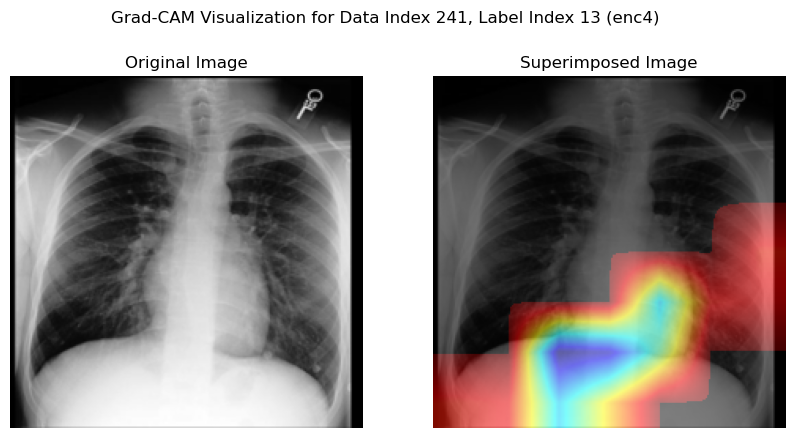

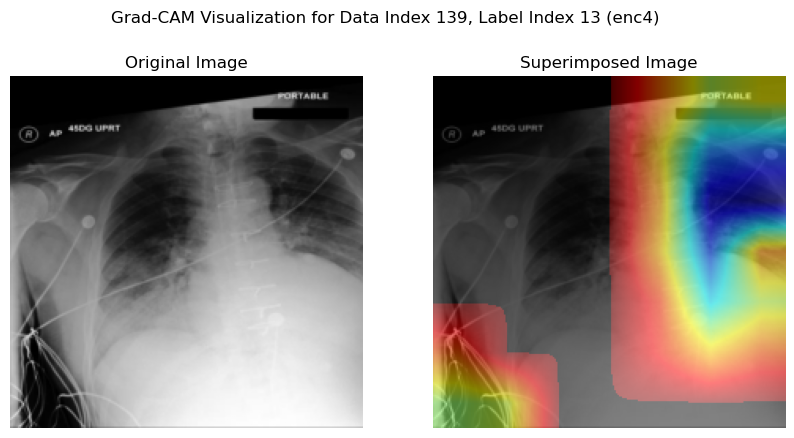

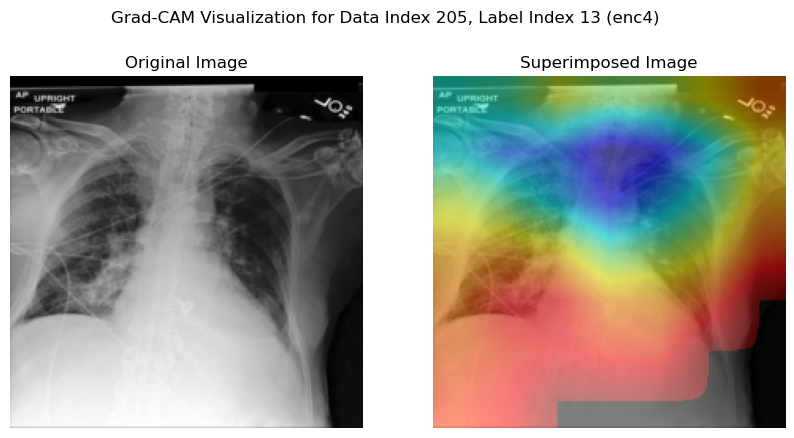

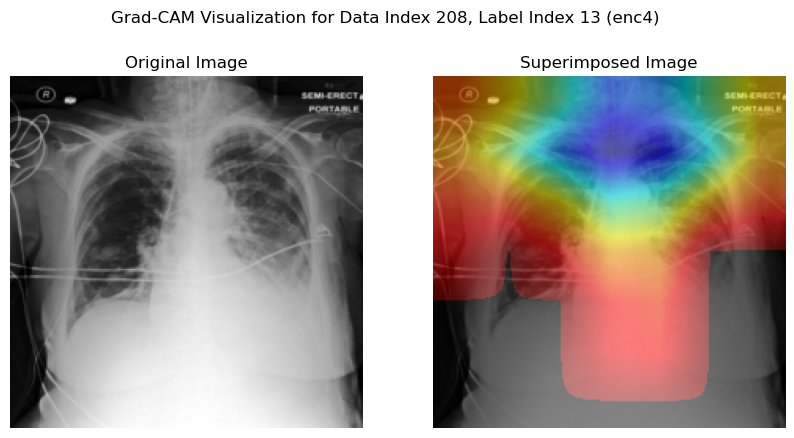

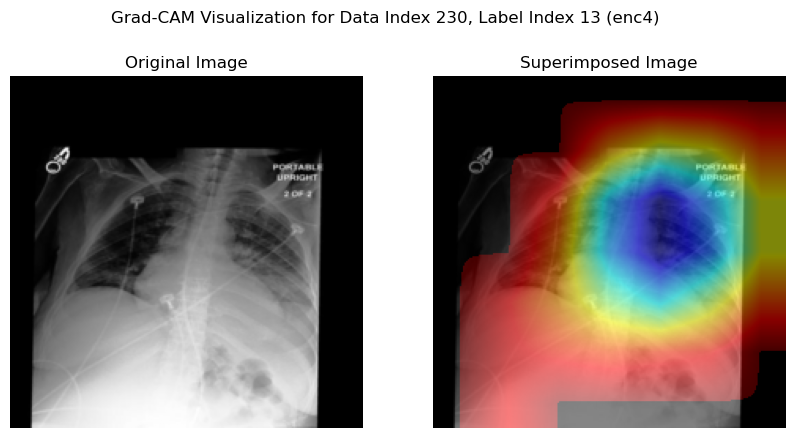

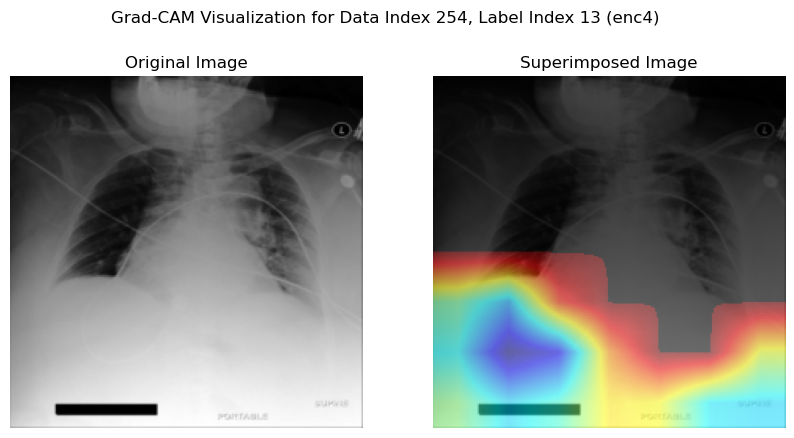

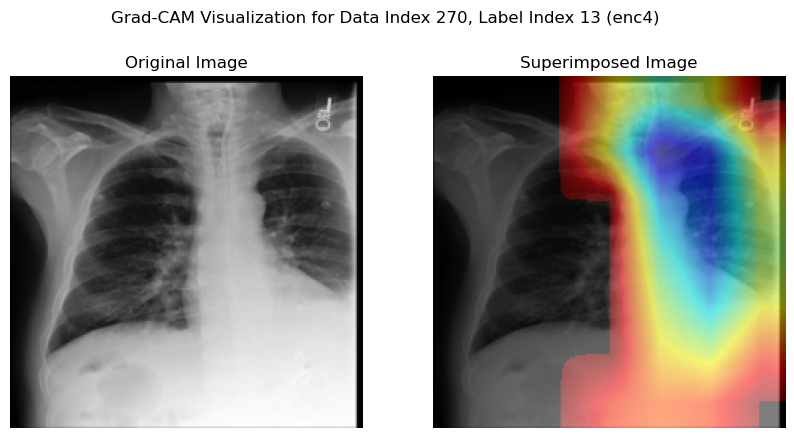

In [ ]:
# you can choose the layer to inspect here

# target_layer = model.layer3[-1]
target_layer = model.layer4[-1]
# target_layer = model.dec1[2]
# target_layer = model.dec2[2]
# target_layer = model.dec3[2]

grad_cam = GradCAM(model, target_layer)

for data_idx in data_idxs:
    image, label = test_dataset[data_idx]
    image = image.unsqueeze(0).to(device)
    label = label.unsqueeze(0).to(device)

    for label_idx in label_idxs:
        target_class = torch.tensor(label_idx, device=device).to(device)

        cam = grad_cam.generate_cam(image, target_class=target_class)

        img_np = image.cpu().squeeze().numpy()
        img_np = np.transpose(img_np, (1, 2, 0))
        img_np = img_np * 0.5 + 0.5

        cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
        cam_resized = np.uint8(255 * cam_resized)

        heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)

        mask = cam_resized > 0
        heatmap[~mask] = [0, 0, 0]

        heatmap = np.float32(heatmap) / 255
        superimposed_img = heatmap + np.float32(img_np)
        superimposed_img = superimposed_img / np.max(superimposed_img)

        plt.figure(figsize=(10, 5))
        plt.suptitle(f'Grad-CAM Visualization for Data Index {data_idx}, Label Index {label_idx} (enc4)')
        
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(img_np)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Superimposed Image')
        plt.imshow(superimposed_img)
        plt.axis('off')
        output_path = f"<save_path>/d{data_idx}_l{label_idx}_(enc4).png"
        
        plt.imsave(output_path, superimposed_img)
        plt.show()